# Homework Starter — Stage 10b: Time Series & Classification
Fill in the TODOs. Use your own dataset or adapt the synthetic generator below.

In [9]:
# Imports
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, TimeSeriesSplit
np.random.seed(7); sns.set(); plt.rcParams['figure.figsize']=(9,4)

## Option A: Use Your Own Data (Recommended)
Load your data here (ensure a DateTime index for time series).

In [2]:
# TODO: load your data
df = pd.read_csv (r"C:\Users\fangyi\bootcamp_fangyi_jiang\project\data\Processed\data_features.csv")

## Option B: Synthetic Generator (Use if you don't have data ready)

In [ ]:
# Synthetic series with regimes & jumps
n=500
dates=pd.bdate_range('2021-01-01', periods=n)
mu = np.where(np.arange(n)<n//2, 0.0003, -0.0001)
sigma = np.where(np.arange(n)<n//2, 0.01, 0.015)
eps = np.random.normal(mu, sigma)
jumps = np.zeros(n); jump_days = np.random.choice(np.arange(20,n-20), size=5, replace=False)
jumps[jump_days] = np.random.normal(0,0.05,size=len(jump_days))
rets = eps + jumps
price = 100*np.exp(np.cumsum(rets))
df = pd.DataFrame({'price':price}, index=dates)
df['ret'] = df['price'].pct_change().fillna(0.0)
df['log_ret'] = np.log1p(df['ret'])
df.head()

## Feature Engineering

In [5]:
# TODO: create at least two features
df['return'] = (df['close'] - df['close'].shift(1))/df['close'].shift(1)
df['lag_1'] = df['return'].shift(1)
df['roll_mean_5'] = df['return'].rolling(5).mean().shift(1) # the moving average is a 3 day moving average for close price, this one is a 5 day for return
# Add your own:
df['momentum'] = df['return'] - df['return'].shift(7)
df['y_next_ret'] = df['return'].shift(-1)
df['y_up'] = (df['y_next_ret']>0).astype(int)
df_feat = df.dropna().copy()
df_feat.head()

,date,close,daily return,moving average,lag_1,roll_mean_5,momentum,y_next_ret,y_up,return
8,2025-04-11,198.15,0.040594,190.410000,-0.042394,-0.009709,0.037458,0.022054,1,0.040594
9,2025-04-14,202.52,0.022054,190.314286,0.040594,0.012987,0.114510,-0.001876,0,0.022054
10,2025-04-15,202.14,-0.001876,192.280000,0.022054,0.024745,0.071011,-0.038933,0,-0.001876
11,2025-04-16,194.27,-0.038933,194.110000,-0.001876,0.034333,-0.002199,0.013950,1,-0.038933
12,2025-04-17,196.98,0.013950,197.618571,-0.038933,-0.004111,0.063768,-0.019393,0,0.013950


## Split

In [ ]:
# Time-aware split
cut=int(len(df_feat)*0.8)
train, test = df_feat.iloc[:cut], df_feat.iloc[cut:]
features=['lag_1','roll_mean_5','momentum']  # extend as you add features
X_tr, X_te = train[features], test[features]
y_tr_reg, y_te_reg = train['y_next_ret'], test['y_next_ret']
y_tr_clf, y_te_clf = train['y_up'], test['y_up']

## Pipeline + Model (Choose one track below)

In [10]:
# Track 1: Forecasting returns
reg = Pipeline([('scaler', StandardScaler()), ('linreg', LinearRegression())])
reg.fit(X_tr, y_tr_reg)
pred = reg.predict(X_te)
rmse = root_mean_squared_error(y_te_reg, pred)
print('RMSE:', rmse)

RMSE: 0.01906070975187902


              precision    recall  f1-score   support

           0       0.50      0.17      0.25        12
           1       0.33      0.71      0.45         7

    accuracy                           0.37        19
   macro avg       0.42      0.44      0.35        19
weighted avg       0.44      0.37      0.33        19



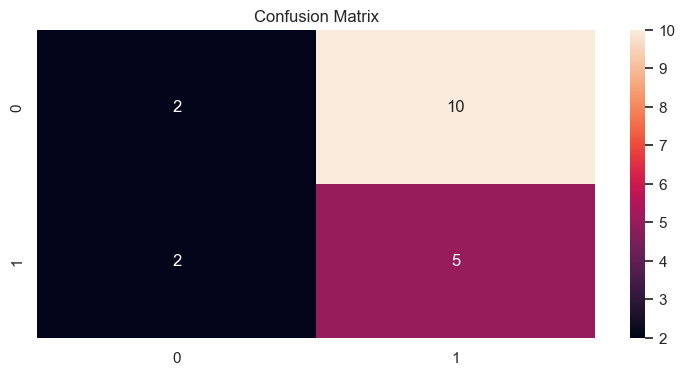

In [7]:
# Track 2: Classification (up/down)
clf = Pipeline([('scaler', StandardScaler()), ('logit', LogisticRegression(max_iter=1000))])
clf.fit(X_tr, y_tr_clf)
predc = clf.predict(X_te)
print(classification_report(y_te_clf, predc))
cm = confusion_matrix(y_te_clf, predc)
sns.heatmap(cm, annot=True, fmt='d'); plt.title('Confusion Matrix'); plt.show()

## Interpretation (Markdown)
- What worked: I am doing a regresion analysis based on stock price and time information, it is not going to work well. There is only a 37% accuracy in predicting whether the stock price will go up or down.
- Where might assumptions fail: The base assumption that autocorrelation can explain most of stock price movement
- How would you extend features or model: I would at least include features like market return and industry specific return.

### Save Notebook
Remember to save as `notebooks/modeling_<team>.ipynb`.